# SOHO MDI and Sunspotter Scores

## Data Exploration 

### Dataset in a Nutshell

- Image data collected by SOHO/MDI
- MDI instrument data / SMART cutouts
- Citizen science project to label (some of) the data (around 60,000 images?): People asked to classify which of two images is more complex
- Complexity score computed from resulting rankings
- Dataset consists of 
    - metadata file (incl. score and image file name)
    - image files


### Download Data

Can be downloaded from XXX <br>


In [8]:
!mkdir -p ./data/MDIComplexityScores
!curl -L 'https://dl.dropboxusercontent.com/s/le0isfa0r5c0w8z/sunspot_data.zip' > sunspot_data.zip
!unzip -q -o sunspot_data.zip -d ./data/MDIComplexityScores
!rm -f sunspot_data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89.2M  100 89.2M    0     0  2351k      0  0:00:38  0:00:38 --:--:-- 2553k1:33  953k


Install dependencies

- on Google Colab you will need to restart your runtime after this step
- when running this locally, make sure to first follow the setup instructions in the [README](../README.md)

In [7]:
#Install dependencies

#- on Google Colab you will need to restart your runtime after this step
#- when running this locally, make sure to first follow the setup instructions in the [README](../README.md)!pip install -U tqdm
!pip install -U torch torchvision
!pip install -U numpy
!pip install -U matplotlib 
!pip install -U Pillow
!pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
     |▌                               | 11.9 MB 67 kB/s eta 3:22:27^C

ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable
     |████▊                           | 2.3 MB 407 kB/s eta 0:00:34^C

ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user
Defaulting to user installation because normal site-packages is not writeable
^C
ERROR: Operation cancelled by user


In [9]:
# Data location
DATADIR = "./data/MDIComplexityScores/data/images/"
METADATA_FILE = "./data/MDIComplexityScores/data/image_metadata.csv"

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

### Load Data Metadata

In [11]:
metadata = pd.read_csv(METADATA_FILE)
metadata.tail()

,Unnamed: 0,#id_x,filename_x,zooniverse_id,angle,area,areafrac,areathesh,bipolesep,c1flr24hr,...,zurich,#id_y,image_id,count,k_value,score,std_dev,#id,filename_y,obs_date
12960,12960,609,530be11e3ae74079c30004cd.jpg,ASZ00000kt,20.8618,126000.0,0.01,16200.0,7.19,1,...,fkc,12961,609,50,8,1478.125224,1.720382,609,20000313_1251_mdiB_2_8906.fits,2000-03-13 12:51:02
12961,12961,3840,530be13e3ae74079c3001e0b.jpg,ASZ00007r7,28.6813,128000.0,-0.02,18300.0,1.22,1,...,fki,12962,3840,50,8,1482.411731,2.839833,3840,20010330_1248_mdiB_2_9393.fits,2001-03-30 12:48:02
12962,12962,7824,530be1663ae74079c3003d2b.jpg,ASZ00004po,21.8158,155000.0,-0.01,22200.0,3.73,1,...,fkc,12963,7824,50,8,1483.847566,1.842268,7824,20020727_1247_mdiB_2_0039.fits,2002-07-27 12:47:00
12963,12963,1224,530be1243ae74079c300099b.jpg,ASZ000093u,51.4482,211000.0,0.06,20800.0,3.16,1,...,ekc,12964,1224,50,8,1487.488269,2.072438,1224,20000522_1251_mdiB_3_8996.fits,2000-05-22 12:51:03
12964,12964,5587,530be14f3ae74079c3002bb1.jpg,ASZ00006ei,56.0346,175000.0,0.05,22300.0,1.22,1,...,dki,12965,5587,50,8,1488.084217,2.509496,5587,20011027_1247_mdiB_2_9672.fits,2001-10-27 12:47:02


Here we are only interested in the `score` variable.

In [12]:
score = metadata.score
score

0         950.403592
1         953.549821
2         954.324334
3         955.205675
4         956.152484
            ...     
12960    1478.125224
12961    1482.411731
12962    1483.847566
12963    1487.488269
12964    1488.084217
Name: score, Length: 12965, dtype: float64

### First Glance at a Sample Image

(360, 289) RGB
(289, 360, 3)
0 255


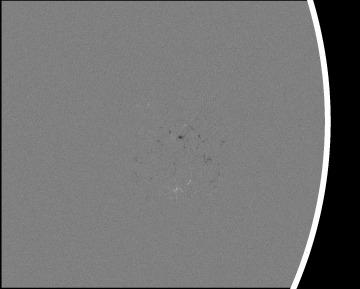

In [13]:
samplefile = metadata.filename_x[0]
image = Image.open(DATADIR + samplefile)
imgarray = np.asarray(image)

print(image.size, image.mode)
print(imgarray.shape)
print(imgarray.min(), imgarray.max())
image

### Load and preprocess the images

- Load image, possibly resize with a suitable ratio.
- Average over color channels.
- Rescale intensity scale to be between `[0,1]`
- Rearrange to have the channels in the first dimension

Data are stored in the format (image_no, x_pixel, y_pixel)

In [14]:
def preprocess_data( image_path, ratio=1 ):

    # create empty data cube
    data = []

    for file in tqdm( metadata.filename_x ):

        # Load and resize image
        image = Image.open(image_path + file)
        new_size = (np.array( image.size ) / ratio).astype( int )
        image = image.resize( new_size )

        # compute the mean along the color channel
        image = np.mean( image, axis=2 )

        # append the image to data list
        data.append( image )
    
    # stack elements of the list into a data cube
    data = np.dstack( data )
    
    # permute dimensions to better format 
    data = np.transpose( data, axes=(2,0,1) )
    
    # make sure pixel values are between 0 and 1
    data = data / 255
    
    return data

In [15]:
data = preprocess_data( DATADIR, ratio=4 )
print( "Data shape: {}".format( data.shape ) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12965/12965 [00:26<00:00, 496.13it/s]


Data shape: (12965, 72, 90)


### Plot Many Examples

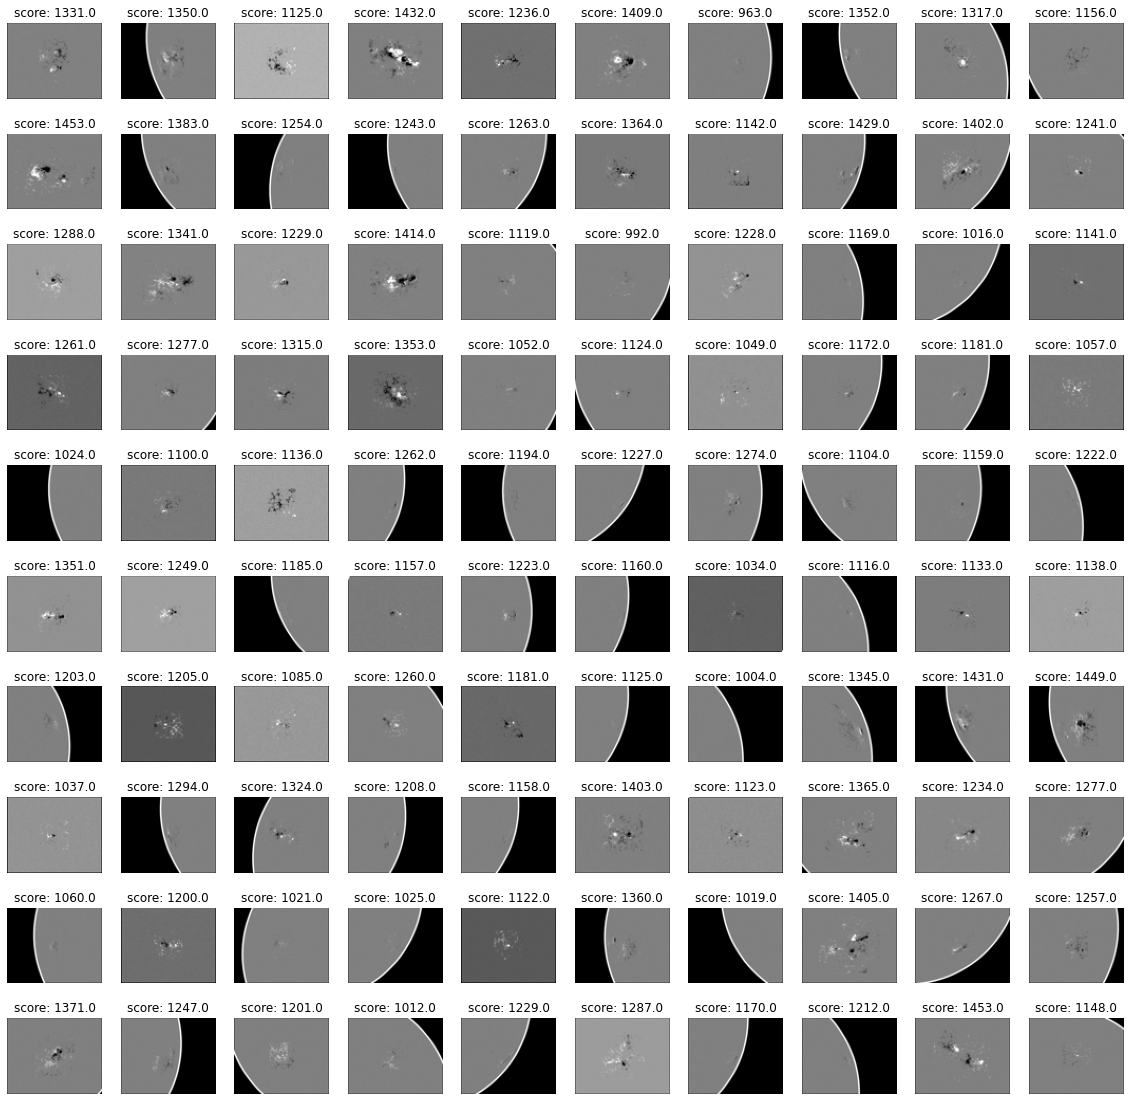

In [16]:
plt.figure( figsize=(20,20) )
n = 10
m = 10
for i in range(n):
    for j in range(m):
        plt.subplot( n, m, n*i+j+1 )
        image = np.random.randint( data.shape[0] )
        plt.title( "score: {}".format( np.round( metadata.score[image]) ) )
        plt.imshow( data[image,:,:], cmap="gray" )
        plt.axis('off')

### Complexity score distribution

(array([ 258.,  728., 1310., 1955., 2317., 2121., 1750., 1326.,  858.,
         342.]),
 array([ 950.40359155, 1004.17165407, 1057.93971658, 1111.7077791 ,
        1165.47584161, 1219.24390413, 1273.01196664, 1326.78002916,
        1380.54809167, 1434.31615419, 1488.0842167 ]),
 <BarContainer object of 10 artists>)

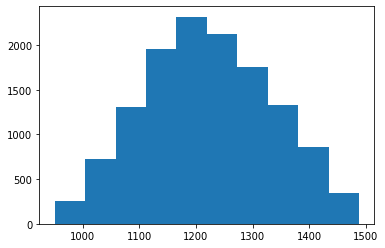

In [17]:
plt.hist( score )

### Split into training and test set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, score, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10372, 72, 90), (2593, 72, 90), (10372,), (2593,))

### Modeling the Data

In [19]:
import torch

X_train_dense = X_train.reshape( X_train.shape[0], -1 )    
X_test_dense = X_test.reshape( X_test.shape[0], -1 )
X_train_dense.shape, X_test_dense.shape

batch_size = 32

X_train_dense_split = torch.split(torch.tensor(X_train_dense).float(),batch_size)
y_train_split = torch.split(torch.tensor(y_train.values).float(),batch_size)

X_test_dense_split = torch.split(torch.tensor(X_test_dense).float(),batch_size)
y_test_split = torch.split(torch.tensor(y_test.values).float(),batch_size)


### Training

In [36]:
from torch.nn import Sequential, Linear, ReLU
from torch.optim import Adam
from torch.nn import MSELoss


model = Sequential(
  Linear(X_train_dense.shape[1], 500), ReLU(),
  Linear(500, 300), ReLU(),
  Linear(300, 1) )

optim = Adam(model.parameters())
mse = MSELoss()

losses_train = []
losses_test = []

for i in range (5): 
   ltr = 0.0
   lte = 0.0
   print ("Epoch: "+str(i))
   for j in range(len(X_train_dense_split)):
      model.zero_grad()
      result = model(X_train_dense_split[j]).view(-1) 
      loss = mse(result,y_train_split[j])
      loss.backward()
      optim.step()
      ltr+=loss.detach()
   for j in range(len(X_test_dense_split)):
      result = model(X_test_dense_split[j]).view(-1)
      loss = mse(result,y_test_split[j])
      lte+=loss.detach()
   losses_train.append(ltr/len(X_train_dense_split))
   losses_test.append(lte/len(X_test_dense_split))
    
print ("done")

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
done


### Learning curve

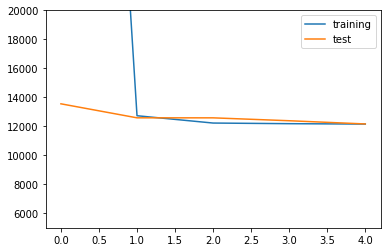

In [38]:
plt.plot( losses_train, label='training' )
plt.plot( losses_test, label='test' )
axes = plt.gca()
axes.set_ylim([5000,20000])
plt.legend()

### Predictions

In [27]:
y_test_pred = model( torch.tensor(X_test_dense).float() ).detach().numpy() 

### Plotting predictions

Text(0, 0.5, 'true')

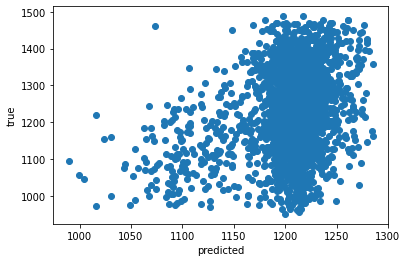

In [28]:
plt.scatter( y_test_pred, y_test )
plt.xlabel("predicted")
plt.ylabel("true")

### Scores

In [29]:
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt( mean_squared_error( y_test, y_test_pred ) )
r2 = r2_score( y_test, y_test_pred )
print("RMSE = {}, R2 = {}".format( rmse, r2 ) )

RMSE = 110.58234931829203, R2 = 0.049906761896128304


## CNN Model

In [52]:
import numpy as np

from torch.nn import Sequential, Conv2d, Linear, Flatten, ReLU
from torch.optim import Adam
from torch.nn import MSELoss


model = Sequential(
  Conv2d(1, 16, 3, 1, padding=1), ReLU(),
  Conv2d(16, 16, 3, 2, padding=1), ReLU(),
  Conv2d(16, 32, 3, 1, padding=1), ReLU(),
  Conv2d(32, 32, 3, 2, padding=1), ReLU(),
  Flatten(),
  Linear(13248, 1000), 
  Linear(1000, 800), 
  Linear(800, 500), 
  Linear(500, 100), 
  Linear(100,1)
)

optim = Adam(model.parameters())
mse = MSELoss()


In [53]:
X_train_cnn = torch.tensor( np.expand_dims( X_train, axis=1 )).float()
X_test_cnn =  torch.tensor( np.expand_dims( X_test, axis=1 )).float()

batch_size = 32

X_train_cnn_split = torch.split(X_train_cnn,batch_size)
X_test_cnn_split = torch.split(X_test_cnn,batch_size)


print (X_train_cnn.shape)

torch.Size([10372, 1, 72, 90])


### Training

In [54]:

losses_train = []
losses_test = []


for i in range (5): 
   print ("Epoch: "+str(i))
   ltr = 0.0
   lte = 0.0
   for j in range(len(X_train_cnn_split)):
      model.zero_grad()
      result = model(X_train_cnn_split[j]).view(-1) 
      loss = mse(result,y_train_split[j])
      loss.backward()
      optim.step()
      ltr+=loss.detach()
   for j in range(len(X_test_cnn_split)):
      result = model(X_test_cnn_split[j]).view(-1)
      loss = mse(result,y_test_split[j])
      lte+=loss.detach()
   losses_train.append(ltr/len(X_train_dense_split))
   losses_test.append(lte/len(X_test_dense_split))
    
print ("done")

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
done


### Learning curve

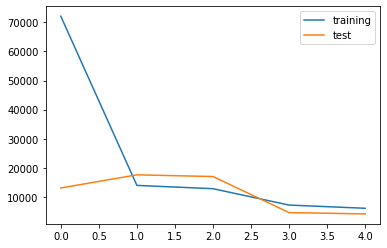

In [55]:
plt.plot( losses_train, label='training' )
plt.plot( losses_test, label='test' )
plt.legend()

### Predictions

In [56]:
y_test_pred = model( X_test_cnn.float() ).detach().numpy() 

### Plotting predictions

Text(0, 0.5, 'true')

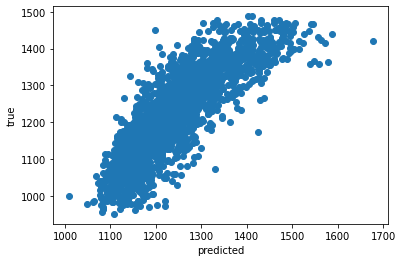

In [57]:
plt.scatter( y_test_pred, y_test )
plt.xlabel("predicted")
plt.ylabel("true")

### Scores

In [58]:

from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt( mean_squared_error( y_test, y_test_pred ) )
r2 = r2_score( y_test, y_test_pred )
print("RMSE = {}, R2 = {}".format( rmse, r2 ) )

RMSE = 64.54561951545084, R2 = 0.6763108443415895
